# ECE 57000 Assignment 3 Exercise

Your Name: Garrett Hurst

Prepare the pacakge we will use.

In [1]:
import time
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

## Exercise 0: Train your model on GPU (0 points)

Some tasks in this assignment can take a long time if you run it on the CPU. For example, based on our solution of Exercise 3 Task 4 (Transfer Learning: finetuning of a pretrained model (resnet18)), it will take roughly 2 hours to train the model end-to-end (complete model and not only the last fc layer) for 1 epoch on CPU. Hence, we highly recommend you try to train your model on GPU.

To do so, first you need to enable GPU on Colab (this will restart the runtime). Click `Runtime`-> `Change runtime type` and select the `Hardware accelerator` there.  You can then run the following code to see if the GPU is correctly initialized and available.

**Note**: If you would like to avoid GPU overages on Colab, we would suggest writing and debugging your code before switching on the GPU runtime. Otherwise, the time you spent debugging code will likely count against your GPU usage. Once you have the code running, you can switch on the GPU runtime and train the model much faster.

In [2]:
print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')

Can I can use GPU now? -- True


### You must manually move your model and data to the GPU (and sometimes back to the cpu)
After setting the GPU up on colab, then you should put your **model** and **data** to GPU. We give a simple example below. You can use `to` function for this task. See [torch.Tensor.to](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to move a tensor to the GPU (probably your mini-batch of data in each iteration) or [torch.nn.Module.to](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.to) to move your NN model to GPU (assuming you create subclass [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)). Note that `to()` of tensor returns a NEW tensor while `to` of a NN model will apply this in-place. To be safe, the best semantics are `obj = obj.to(device)`. For printing, you will need to move a tensor back to the CPU via the `cpu()` function.

Once the model and input data are on the GPU, everything else can be done the same.  This is the beauty of PyTorch GPU acceleration.  None of the other code needs to be altered.

To summarize, you need to 1) enable GPU acceleration in Colab, 2) put the model on the GPU, and 3) put the input data (i.e., the batch of samples) onto the GPU using `to()` after it is loaded by the data loaders (usually you only put one batch of data on the GPU at a time).

In [3]:
rand_tensor = torch.rand(5,2)
simple_model = nn.Sequential(nn.Linear(2,10), nn.ReLU(), nn.Linear(10,1))
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

# device = torch.device('cuda')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ----------- <Your code> ---------------
# Move rand_tensor and model onto the GPU device
rand_tensor = rand_tensor.to(device)
simple_model = simple_model.to(device)
# --------- <End your code> -------------
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

input is on cpu
model parameters are on [device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]
output is on cpu
input is on cuda:0
model parameters are on [device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0)]
output is on cuda:0


## Exercise 1: Why use a CNN rather than only fully connected layers? (40 points)

In this exercise, you will build two models for the **MNIST** dataset: one uses only fully connected layers and another uses a standard CNN layout (convolution layers everywhere except the last layer is fully connected layer). Note, you will need to use cross entropy loss as your objective function. The two models should be built with roughly the same accuracy performance, your task is to compare the number of network parameters (a huge number of parameters can affect training/testing time, memory requirements, overfitting, etc.).

### Task 1: Prepare train and test function

We will create our train and test procedure in these two functions. The train function should apply one epoch of training. The functions inputs should take everything we need for training and testing and return some logs.

#### Arguments requirement:
* For the `train` function, it takes the `model`, `loss_fn`, `optimizer`, `train_loader `, and `epoch` as arguments.
    * `model`: the classifier, or deep neural network, should be an instance of `nn.Module`.
    * `loss_fn`: the loss function instance. For example, `nn.CrossEntropy()`, or `nn.L1Loss()`, etc.
    * `optimizer`: should be an instance of `torch.optim.Optimizer`. For example, it could be `optim.SGD()` or `optim.Adam()`, etc.
    * `train_loader `: should be an instance of `torch.utils.data.DataLoader`.
    * `epoch`: the current number of epoch. Only used for log printing.(default: 1.) 

* For the `test` function, it takes all the inputs above except for the optimizer (and it takes a test loader instead of a train loader).

#### Log requirement:
Here are some further requirements:
* In the `train` function, print the log 8-10 times per epoch. The print statement should be: 
```python
print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader .dataset)}] Loss: {loss.item():.3f}')
```
* In the `test` function, print the log after the testing. The print statement is: 
```python
print(f"Test result on epoch {epoch}: total sample: {total_num}, Avg loss: {test_stat['loss']:.3f}, Acc: {100*test_stat['accuracy']:.3f}%")
```

#### Return requirement 
* The `train` function should return a list, which the element is the loss per batch, i.e., one loss value for every batch.
* The `test` function should return a dictionary with three keys: "loss", "accuracy", and "prediction". The values are the average loss of all the test_loader , average accuracy of all the test dataset, and the prediction of all test dataset.

#### Other requirement:
* In the `train` function, the model should be updated in-place, i.e., do not copy the model inside `train` function.

In [4]:
def train(model: nn.Module, 
          loss_fn: nn.modules.loss._Loss, 
          optimizer: torch.optim.Optimizer, 
          train_loader : torch.utils.data.DataLoader, 
          epoch: int=0)-> List:
    # ----------- <Your code> ---------------
    model.train() 
    train_loss = []
    
    for batch_idx, (images, labels) in enumerate(train_loader ):
        images = images.to(next(model.parameters()).device)
        labels = labels.to(next(model.parameters()).device)
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        if batch_idx % (len(train_loader ) // 10) == 0:
            print(f'Epoch {epoch}: [{batch_idx * len(images)}/{len(train_loader .dataset)}] Loss: {loss.item():.3f}')

    # ----------- <End Your code> ---------------
    assert len(train_loss) == len(train_loader )
    return train_loss

def test(model: nn.Module, 
         loss_fn: nn.modules.loss._Loss, 
         test_loader : torch.utils.data.DataLoader, 
         epoch: int=0)-> Dict:
    # ----------- <Your code> ---------------
    model.eval() 
    test_loss   = 0
    correct     = 0
    total_num   = len(test_loader .dataset)
    predictions = []

    with torch.no_grad():
        for images, labels in test_loader :
            images = images.to(next(model.parameters()).device)
            labels = labels.to(next(model.parameters()).device)

            outputs = model(images)
            test_loss += loss_fn(outputs, labels).item()  
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            predictions.append(preds.cpu())

    avg_loss    = test_loss / len(test_loader )
    accuracy    = correct / total_num
    predictions = torch.cat(predictions, dim=0)
    print(f"Test result on epoch {epoch}: total sample: {total_num}, Avg loss: {avg_loss:.3f}, Acc: {100 * accuracy:.3f}%")

    test_stat = {
        "loss": avg_loss,
        "accuracy": accuracy,
        "prediction": predictions
    }

    # ----------- <Your code> ---------------
    # dictionary should include loss, accuracy and prediction
    assert "loss" and "accuracy" and "prediction" in test_stat.keys()
    # "prediction" value should be a 1D tensor
    assert len(test_stat["prediction"]) == len(test_loader .dataset)
    assert isinstance(test_stat["prediction"], torch.Tensor)
    return test_stat


### Task 2: Following the structure used in the instructions, you should create

*   One network named `OurFC` which should consist with only fully connected layers

  *   You should decide how many layers and how many hidden dimensions you want in your network 
  *   Your final accuracy on the test dataset should lie roughly around 97% ($\pm$2%)
  *   There is no need to make the neural network unnecessarily complex, your total training time should no longer than 3 mins

*   Another network named `OurCNN` which applys a standard CNN structure
  *   Again, you should decide how many layers and how many channels you want for each layer.
  *   Your final accuracy on the test dataset should lie roughly around 97% ($\pm$2%)
  *   A standard CNN structure can be composed as **[Conv2d, MaxPooling, ReLU] x num_conv_layers + FC x num_fc_layers**

* Train and test your network on MNIST data as in the instructions. 
* Notice You can always use the `train` and `test` function you write throughout this assignment.
* The code below will also print out the number of parameters for both neural networks to allow comparison.
* (You can use multiple cells if helpful but make sure to run all of them to receive credit.)


In [5]:
# Download MNIST and transformation
# ----------- <Your code> ---------------
import os
data_dir = './data'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

transform = torchvision.transforms.Compose([transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root=data_dir, download=True, train=True, transform=transform)
mnist_test  = torchvision.datasets.MNIST(root=data_dir, download=True, train=False, transform=transform)

batch_sz = 128
train_loader  = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=batch_sz, shuffle=True)
test_loader   = torch.utils.data.DataLoader(dataset=mnist_test,  batch_size=batch_sz, shuffle=False)

tr_features, tr_labels = next(iter(train_loader ))
ts_features, ts_labels = next(iter(test_loader ))
print(f'data loaded: ')
print(f'TRAIN feature shape: {tr_features.shape}')
print(f'TRAIN label   shape: {tr_labels.shape}')
print(f'TEST  feature shape: {ts_features.shape}')
print(f'TEST  label   shape: {ts_labels.shape}')
# ----------- <End Your code> -------------

data loaded: 
TRAIN feature shape: torch.Size([128, 1, 28, 28])
TRAIN label   shape: torch.Size([128])
TEST  feature shape: torch.Size([128, 1, 28, 28])
TEST  label   shape: torch.Size([128])


In [6]:
# Build OurFC class and OurCNN class.
# ----------- <Your code> ---------------
class OurFC(nn.Module):
    def __init__(self, d_in=28*28, d_out=10, *d_hN):
        super().__init__()
        if not all(isinstance(d_hi, int) for d_hi in d_hN):
            raise TypeError('Oi - make sure all extra hidden layer dimentions are integers')
        if len(d_hN) == 0:
            d_hN = (1028, 256)
        
        d_hN = list(d_hN) + [d_out,]
        d_prev = d_hN.pop(0)
        self.layers = nn.ModuleList([nn.Linear(d_in, d_prev),])
        for d_hi in d_hN:
            self.layers.append(nn.Linear(d_prev, d_hi))
            d_prev = d_hi

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        # compute all hidden layer vals 
        if len(self.layers) > 1:
            for layer in self.layers[:-1]:
                x = F.relu(layer(x))
        # compute last layer 
        return F.log_softmax(self.layers[-1](x))    

class OurCNN(nn.Module):
    def __init__(self, in_w=28, in_h=28, in_c=1, num_classes=10):
        super().__init__() 
        conv1_sz = 16
        conv2_sz = 32
        pool_k   = 2
        self.conv1 = nn.Conv2d(in_c, conv1_sz, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(conv1_sz, conv2_sz, kernel_size=3, stride=1, padding=1)
        self.pool  = nn.MaxPool2d(kernel_size=pool_k, stride=pool_k, padding=0)
        self.fc1   = nn.Linear(conv2_sz * in_w * in_h // ((2*pool_k) ** 2), 32)
        self.fc2   = nn.Linear(32, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)
# ----------- <End Your code> -------------

In [7]:
# Let's first train the FC model. Below are there common hyperparameters.
criterion = nn.CrossEntropyLoss()

start = time.time()
max_epoch = 3
# ----------- <Your code> ---------------
learning_rate = 0.001
num_epochs    = max_epoch

model_fc = OurFC().to(device)
optimizer_fc = optim.Adam(model_fc.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs + 1):
    train_loss = train(model_fc, criterion, optimizer_fc, train_loader , epoch)
    test_stat  = test(model_fc,  criterion, test_loader, epoch)

# ----------- <End Your code> ---------------
end = time.time()
print(f'Finished Training after {end-start} s ')

C:\Users\hurst\AppData\Local\Temp\ipykernel_32404\525692458.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(self.layers[-1](x))


Epoch 1: [0/60000] Loss: 2.303
Epoch 1: [5888/60000] Loss: 0.333
Epoch 1: [11776/60000] Loss: 0.323
Epoch 1: [17664/60000] Loss: 0.214
Epoch 1: [23552/60000] Loss: 0.120
Epoch 1: [29440/60000] Loss: 0.149
Epoch 1: [35328/60000] Loss: 0.173
Epoch 1: [41216/60000] Loss: 0.182
Epoch 1: [47104/60000] Loss: 0.139
Epoch 1: [52992/60000] Loss: 0.217
Epoch 1: [58880/60000] Loss: 0.102
Test result on epoch 1: total sample: 10000, Avg loss: 0.109, Acc: 96.600%
Epoch 2: [0/60000] Loss: 0.094
Epoch 2: [5888/60000] Loss: 0.135
Epoch 2: [11776/60000] Loss: 0.047
Epoch 2: [17664/60000] Loss: 0.045
Epoch 2: [23552/60000] Loss: 0.087
Epoch 2: [29440/60000] Loss: 0.090
Epoch 2: [35328/60000] Loss: 0.057
Epoch 2: [41216/60000] Loss: 0.025
Epoch 2: [47104/60000] Loss: 0.216
Epoch 2: [52992/60000] Loss: 0.088
Epoch 2: [58880/60000] Loss: 0.042
Test result on epoch 2: total sample: 10000, Avg loss: 0.084, Acc: 97.310%
Epoch 3: [0/60000] Loss: 0.020
Epoch 3: [5888/60000] Loss: 0.111
Epoch 3: [11776/60000] Lo

In [8]:
# Let's then train the OurCNN model.
start = time.time()
# ----------- <Your code> ---------------
learning_rate = 0.001
num_epochs    = 3

model_cnn = OurCNN().to(device)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs + 1):
    train_loss = train(model_cnn, criterion, optimizer_cnn, train_loader , epoch)
    test_stat  = test(model_cnn,  criterion, test_loader, epoch)

# ----------- <End Your code> ---------------
end = time.time()
print(f'Finished Training after {end-start} s ')

C:\Users\hurst\AppData\Local\Temp\ipykernel_32404\525692458.py:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch 1: [0/60000] Loss: 2.302
Epoch 1: [5888/60000] Loss: 0.842
Epoch 1: [11776/60000] Loss: 0.506
Epoch 1: [17664/60000] Loss: 0.401
Epoch 1: [23552/60000] Loss: 0.267
Epoch 1: [29440/60000] Loss: 0.292
Epoch 1: [35328/60000] Loss: 0.111
Epoch 1: [41216/60000] Loss: 0.125
Epoch 1: [47104/60000] Loss: 0.130
Epoch 1: [52992/60000] Loss: 0.110
Epoch 1: [58880/60000] Loss: 0.223
Test result on epoch 1: total sample: 10000, Avg loss: 0.113, Acc: 96.420%
Epoch 2: [0/60000] Loss: 0.127
Epoch 2: [5888/60000] Loss: 0.202
Epoch 2: [11776/60000] Loss: 0.167
Epoch 2: [17664/60000] Loss: 0.115
Epoch 2: [23552/60000] Loss: 0.082
Epoch 2: [29440/60000] Loss: 0.116
Epoch 2: [35328/60000] Loss: 0.026
Epoch 2: [41216/60000] Loss: 0.161
Epoch 2: [47104/60000] Loss: 0.047
Epoch 2: [52992/60000] Loss: 0.087
Epoch 2: [58880/60000] Loss: 0.048
Test result on epoch 2: total sample: 10000, Avg loss: 0.062, Acc: 97.930%
Epoch 3: [0/60000] Loss: 0.020
Epoch 3: [5888/60000] Loss: 0.073
Epoch 3: [11776/60000] Lo

In [9]:
ourfc = OurFC()
total_params = sum(p.numel() for p in ourfc.parameters())
print(f'OurFC has a total of {total_params} parameters')

ourcnn = OurCNN()
total_params = sum(p.numel() for p in ourcnn.parameters())
print(f'OurCNN has a total of {total_params} parameters')

OurFC has a total of 1072974 parameters
OurCNN has a total of 55338 parameters


Questions (0 points, just for understanding): Which one has more parameters?  Which one is likely to have less computational cost when deployed? Which one took longer to train?

## Exercise 2: Train classifier on CIFAR-10 data. (30 points)
Now, lets move our dataset to color images. CIFAR-10 dataset is another widely used dataset. Here all images have colors, i.e each image has 3 color channels instead of only one channel in MNIST. You need to pay more attention to the dimension of the data as it passes through the layers of your network.

### Task 1: Create data loaders 
* Load CIFAR10 train and test datas with appropriate composite transform where the normalize transform should be `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])`.
* Set up a `train_loader ` and `test_loader` for the CIFAR-10 data with a batch size of 9 similar to the instructions.
* The code below will plot a 3 x 3 subplot of images including their labels. (do not modify)

Files already downloaded and verified
Files already downloaded and verified


C:\Users\hurst\AppData\Local\Temp\ipykernel_32404\3835743650.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


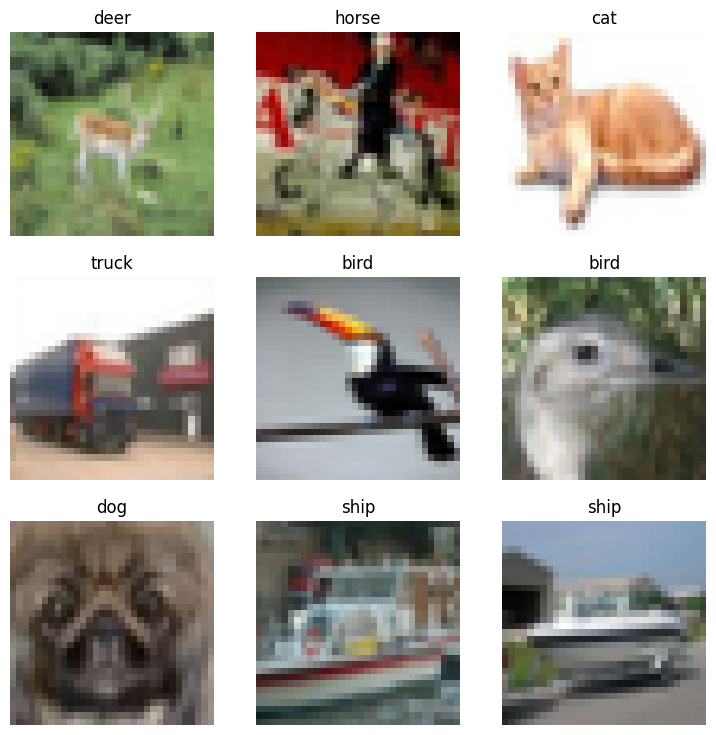

In [10]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Create the appropriate transform, load/download CIFAR10 train and test datasets with transform
# ----------- <Your code> ---------------
transform = torchvision.transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=False, transform=transform)
# ----------- <End Your code> ---------------

# Define trainloader and testloader
# ----------- <Your code> ---------------
batch_sz = 128
train_loader  = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_sz, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=batch_sz, shuffle=False)
# ----------- <End Your code> ---------------

# Code to display images
batch_idx, (images, targets) = next(enumerate(train_loader )) #fix!!!!!
fig, ax = plt.subplots(3,3,figsize = (9,9))
for i in range(3):
    for j in range(3):
        image = images[i*3+j].permute(1,2,0)
        image = image/2 + 0.5
        ax[i,j].imshow(image)
        ax[i,j].set_axis_off()
        ax[i,j].set_title(f'{classes[targets[i*3+j]]}')
fig.show()

### Task 2: Create CNN and train it
Set up a convolutional neural network and have your data trained on it. You have to decide all the details in your network, overall your neural network should meet the following standards to receive full credit:

*   You should not use more than three convolutional layers and three fully connected layers
*   Accuracy on the test dataset should be **above** 50%



In [11]:
# Create CNN network.
# ----------- <Your code> ---------------

class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super().__init__() 
        self.conv1 = nn.Conv2d(3,  32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x) 
    
# ----------- <End Your code> --------------- 

In [12]:
# Train your neural network here.
start = time.time()
max_epoch = 4
# ----------- <Your code> ---------------
# Define net
learning_rate = 0.001
num_epochs    = max_epoch

net = CIFAR10_CNN().to(device)
optimizer_cnn = optim.Adam(net.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs + 1):
    train_loss = train(net, criterion, optimizer_cnn, train_loader , epoch)
    test_stat  = test(net,  criterion, test_loader, epoch)

# ----------- <End Your code> ---------------
output = test(net, criterion, test_loader, epoch)
end = time.time()
print(f'Finished Training after {end-start} s ')

C:\Users\hurst\AppData\Local\Temp\ipykernel_32404\1586129753.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch 1: [0/50000] Loss: 2.303
Epoch 1: [4992/50000] Loss: 1.710
Epoch 1: [9984/50000] Loss: 1.647
Epoch 1: [14976/50000] Loss: 1.323
Epoch 1: [19968/50000] Loss: 1.323
Epoch 1: [24960/50000] Loss: 1.488
Epoch 1: [29952/50000] Loss: 1.413
Epoch 1: [34944/50000] Loss: 1.351
Epoch 1: [39936/50000] Loss: 1.306
Epoch 1: [44928/50000] Loss: 0.989
Epoch 1: [31200/50000] Loss: 1.143
Test result on epoch 1: total sample: 10000, Avg loss: 1.124, Acc: 59.820%
Epoch 2: [0/50000] Loss: 1.020
Epoch 2: [4992/50000] Loss: 0.983
Epoch 2: [9984/50000] Loss: 1.094
Epoch 2: [14976/50000] Loss: 1.063
Epoch 2: [19968/50000] Loss: 1.107
Epoch 2: [24960/50000] Loss: 1.021
Epoch 2: [29952/50000] Loss: 0.886
Epoch 2: [34944/50000] Loss: 0.939
Epoch 2: [39936/50000] Loss: 1.021
Epoch 2: [44928/50000] Loss: 1.013
Epoch 2: [31200/50000] Loss: 0.919
Test result on epoch 2: total sample: 10000, Avg loss: 0.948, Acc: 66.490%
Epoch 3: [0/50000] Loss: 0.934
Epoch 3: [4992/50000] Loss: 0.804
Epoch 3: [9984/50000] Loss:

### Task 3: Plot misclassified test images
Plot some misclassified images in your test dataset:

*   select three images that are **misclassified** by your neural network
*   label each images with true label and predicted label
*   use `detach().cpu()` when plotting images if the image is in gpu

C:\Users\hurst\AppData\Local\Temp\ipykernel_32404\3568363329.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


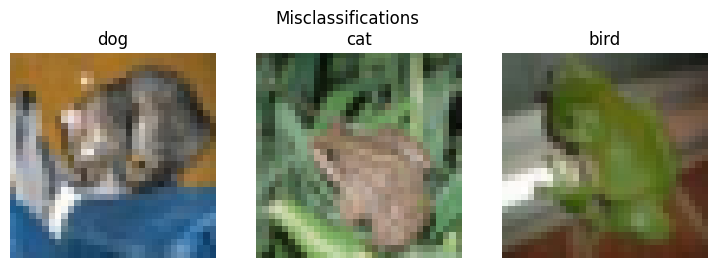

In [13]:
total_images = 3
predictions = output['prediction']
targets = torch.tensor(testset.targets)
# ----------- <Your code> ---------------
fig, ax = plt.subplots(1,total_images,figsize = (3*total_images,3))
plotted = 0
for (img, label), pred in zip(testset, predictions): 
    if plotted == total_images: 
        break
    elif label != pred:   
        image = img.permute(1,2,0)
        image = image/2 + 0.5
        ax[plotted].imshow(image)
        ax[plotted].set_axis_off()
        ax[plotted].set_title(f'{classes[pred]}')
        plotted += 1
fig.suptitle('Misclassifications')
fig.show()
# ----------- <End Your code> ---------------    

Questions (0 points): Are the mis-classified images also misleading to human eyes?

## Exercise 3: Transfer Learning (30 points)

In practice, people won't train an entire CNN from scratch, because it is relatively rare to have a dataset of sufficient size (or sufficient computational power). Instead, it is common to pretrain a CNN on a very large dataset and then use the CNN either as an initialization or a fixed feature extractor for the task of interest.

In this task, you will learn how to use a pretrained CNN for CIFAR-10 classification.

### Task1: Load pretrained model

`torchvision.models` (https://pytorch.org/vision/stable/models.html) contains definitions of models for addressing different tasks, including: image classification, pixelwise semantic segmentation, object detection, instance segmentation, person keypoint detection and video classification.

First, you should load the **pretrained** ResNet-18 that has already been trained on [ImageNet](https://www.image-net.org/) using `torchvision.models`. If you are interested in more details about Resnet-18, read this paper https://arxiv.org/pdf/1512.03385.pdf.

In [14]:
resnet18 = models.resnet18(pretrained=True)
resnet18 = resnet18.to(device)

C:\Users\hurst\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hurst\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Task2: Create data loaders for CIFAR-10

Then you need to create a modified dataset and dataloader for CIFAR-10. Importantly, the model you load has been trained on **ImageNet** and it expects inputs as mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be **at least** 224. So you need to preprocess the CIFAR-10 data to make sure it has a height and width of 224. Thus, you should add a transform when loading the CIFAR10 dataset (see [`torchvision.transforms.Resize`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Resize)).
This should be added appropriately to the `transform` you created in a previous task.

In [15]:
# Create your dataloader here
# ----------- <Your code> ---------------
transform = torchvision.transforms.Compose([transforms.ToTensor(), 
                                            transforms.Resize((224,224)),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=False, transform=transform)
# ----------- <End Your code> ---------------

# Define trainloader and testloader
# ----------- <Your code> ---------------
batch_sz = 128
train_loader  = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_sz, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=batch_sz, shuffle=False)
# ----------- <End Your code> ---------------

Files already downloaded and verified
Files already downloaded and verified


### Task3: Classify test data on pretrained model

Use the model you load to classify the **test** CIFAR-10 data and print out the test accuracy.

Don't be surprised if the accuracy is bad!

In [16]:
# ----------- <Your code> ---------------
test(resnet18, criterion, test_loader, 0)
# ----------- <End Your code> ---------------

Test result on epoch 0: total sample: 10000, Avg loss: 11.730, Acc: 0.030%


{'loss': 11.730486133430578,
 'accuracy': 0.0003,
 'prediction': tensor([ 51, 473, 408,  ..., 906,  47, 901])}

### Task 4: Fine-tune (i.e., update) the pretrained model for CIFAR-10

Now try to improve the test accuracy. We offer several possible solutions:

(1) You can try to directly continue to train the model you load with the CIFAR-10 training data. 

(2) For efficiency, you can try to freeze part of the parameters of the loaded models. For example, you can first freeze all parameters by

```
for param in model.parameters():
    param.requires_grad = False
```
and then unfreeze the last few layers by setting `somelayer.requires_grad=True`.

You are also welcome to try any other approach you can think of.


**Note:** You must print out the test accuracy and to get full credits, the test accuracy should be at least **80%**.

In [17]:
# Directly train the whole model.
start = time.time()
#----------- <Your code> ---------------
learning_rate = 0.001
num_epochs    = 6

optimizer_resnet = optim.Adam(resnet18.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs + 1):
    train_loss = train(resnet18, criterion, optimizer_resnet, train_loader , epoch)
    test_stat  = test(resnet18,  criterion, test_loader, epoch)

# ----------- <End Your code> ---------------
test(resnet18, criterion, test_loader, epoch)
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 1: [0/50000] Loss: 10.061
Epoch 1: [4992/50000] Loss: 0.734
Epoch 1: [9984/50000] Loss: 0.614
Epoch 1: [14976/50000] Loss: 0.576
Epoch 1: [19968/50000] Loss: 0.446
Epoch 1: [24960/50000] Loss: 0.412
Epoch 1: [29952/50000] Loss: 0.418
Epoch 1: [34944/50000] Loss: 0.365
Epoch 1: [39936/50000] Loss: 0.355
Epoch 1: [44928/50000] Loss: 0.344
Epoch 1: [31200/50000] Loss: 0.328
Test result on epoch 1: total sample: 10000, Avg loss: 0.564, Acc: 82.100%
Epoch 2: [0/50000] Loss: 0.254
Epoch 2: [4992/50000] Loss: 0.207
Epoch 2: [9984/50000] Loss: 0.310
Epoch 2: [14976/50000] Loss: 0.280
Epoch 2: [19968/50000] Loss: 0.420
Epoch 2: [24960/50000] Loss: 0.330
Epoch 2: [29952/50000] Loss: 0.228
Epoch 2: [34944/50000] Loss: 0.299
Epoch 2: [39936/50000] Loss: 0.159
Epoch 2: [44928/50000] Loss: 0.238
Epoch 2: [31200/50000] Loss: 0.288
Test result on epoch 2: total sample: 10000, Avg loss: 0.406, Acc: 86.250%
Epoch 3: [0/50000] Loss: 0.216
Epoch 3: [4992/50000] Loss: 0.268
Epoch 3: [9984/50000] Loss

In [18]:
# Load another resnet18 instance, only unfreeze the outer layers. 
# ----------- <Your code> ---------------
resnet18 = models.resnet18(pretrained=True)
resnet18 = resnet18.to(device)
for param in list(resnet18.parameters())[:-5]:
    param.requires_grad = False
# ----------- <End Your code> ---------------

In [19]:
# Train the model!!
start = time.time()
# ----------- <Your code> ---------------
learning_rate = 0.001
num_epochs    = 6

optimizer_resnet = optim.Adam(resnet18.parameters(), lr=learning_rate)

for epoch in range(1, num_epochs + 1):
    train_loss = train(resnet18, criterion, optimizer_resnet, train_loader , epoch)
    test_stat  = test(resnet18,  criterion, test_loader, epoch) 
# ----------- <End Your code> ---------------
test(resnet18, criterion, test_loader)
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 1: [0/50000] Loss: 10.170
Epoch 1: [4992/50000] Loss: 0.774
Epoch 1: [9984/50000] Loss: 0.584
Epoch 1: [14976/50000] Loss: 0.455
Epoch 1: [19968/50000] Loss: 0.530
Epoch 1: [24960/50000] Loss: 0.526
Epoch 1: [29952/50000] Loss: 0.623
Epoch 1: [34944/50000] Loss: 0.415
Epoch 1: [39936/50000] Loss: 0.571
Epoch 1: [44928/50000] Loss: 0.645
Epoch 1: [31200/50000] Loss: 0.541
Test result on epoch 1: total sample: 10000, Avg loss: 0.504, Acc: 82.460%
Epoch 2: [0/50000] Loss: 0.409
Epoch 2: [4992/50000] Loss: 0.439
Epoch 2: [9984/50000] Loss: 0.404
Epoch 2: [14976/50000] Loss: 0.460
Epoch 2: [19968/50000] Loss: 0.464
Epoch 2: [24960/50000] Loss: 0.301
Epoch 2: [29952/50000] Loss: 0.299
Epoch 2: [34944/50000] Loss: 0.391
Epoch 2: [39936/50000] Loss: 0.399
Epoch 2: [44928/50000] Loss: 0.392
Epoch 2: [31200/50000] Loss: 0.386
Test result on epoch 2: total sample: 10000, Avg loss: 0.475, Acc: 83.430%
Epoch 3: [0/50000] Loss: 0.348
Epoch 3: [4992/50000] Loss: 0.249
Epoch 3: [9984/50000] Loss